In [137]:
function init()
    I = 200
    u = zeros(Float64,I+1)
    x = zeros(Float64,I+1)
    l = zeros(Float64,I)
    p = zeros(Float64,I)
    ρ = zeros(Float64,I)
    m = zeros(Float64,I)
    e = zeros(Float64,I)
    γ = 1.4
    
    Δx = 1/I
    l .= Δx
    
    tt = 0.1
    sf =0.2
    # init
    
    for i in 1:I 
        u[i] = 0
        
        
        if i >I/2
            p[i] = 0.1
            ρ[i] = 0.1
            m[i] =ρ[i]*Δx
        else
            p[i] = 1.0
            ρ[i] = 1.0
            m[i] = ρ[i] *Δx
        end
    end
    
    for i in 1:I+1
        x[i] = i*Δx
    end
    
    
    e = pToe(p,ρ,γ)
return sf,tt,γ,u,x,m,p
end

            
            

init (generic function with 1 method)

In [138]:
sf,tt,γ,u,x,m,p = init()
u,x,p,ρ = timeSolve(sf, tt, γ, u, x, m,p)

0.0008451542547284887
0.001530174019087381
0.0021011753216711422
0.00259159111596646
0.003023085701127379
0.0034100768646778837
0.003762548707938625
0.0040876673948508
0.004390730496773902
0.004675749180541969
0.004945821013997962
0.005203378016279944
0.005450357154258621
0.005688320765937192
0.00591854357183307
0.006142076748715813
0.006359795864440521
0.006572437213114934
0.006780625658745206
0.0069848961649014085
0.007185710568223782
0.00738347073160546
0.007578528919280595
0.007771196027367643
0.00796174815197224
0.008150431864844345
0.008337468482102456
0.008523057546923727
0.008707379697129106
0.008890599049675164
0.009072865203666354
0.009254314939780581
0.009435073675575318
0.00961525672194199
0.009794970375153622
0.00997431287081703
0.010153375220029012
0.010332241943675336
0.010510991717709584
0.010689697940079618
0.010868429228465261
0.011047249856934921
0.011226220138853157
0.011405396762748212
0.011584833087290424
0.011764584244396168
0.01194471044694927
0.0121252763190361

0.0850227799915646
0.08522640517286782
0.08543001939760585
0.08563362291371959
0.08583721595788577
0.08604079875604027
0.08624437152387684
0.08644793446732213
0.0866514877829888
0.08685503165860771
0.08705856627344039
0.08726209179867288
0.08746560839779212
0.0876691162269455
0.08787261446832852
0.08807610173410708
0.08827957827802427
0.08848304434195421
0.08868650015647335
0.08888994594140577
0.08909338190634397
0.08929680825114618
0.08950022516641148
0.08970363283393386
0.08990703142713602
0.09011042111148428
0.09031380204488511
0.09051717437806446
0.09072053825493055
0.09092389381292093
0.09112724118333457
0.09133058049164969
0.0915339118578279
0.09173723507697967
0.09194054863598733
0.09214385272917469
0.09234714754199225
0.09255043325147493
0.09275371002667884
0.09295697802909801
0.09316023741306177
0.09336348832611376
0.09356673090937315
0.09376996529787894
0.09397319162091787
0.09417641000233673
0.09437962056083961
0.09458282341027076
0.09478601865988358
0.09498920641459631
0.09

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  3.69017e-16, 3.29698e-16, 2.86716e-16, 2.46771e-16, 2.05912e-16, 1.64065e-16, 1.20325e-16, 8.04627e-17, 4.00893e-17, 0.0], [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05  …  0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0, 1.005], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

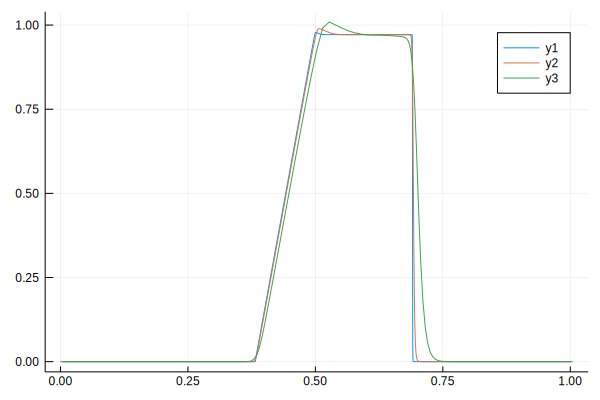

In [139]:
using Plots
plot!(x,u)

In [3]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [71]:
function timeSolve(sf, tt,γ,u,x,m,p)
    t= 0.0

    I, = size(m)
    ρ = zeros(Float64,I)
       while t<tt
#for i in 1:3000
        dt=CFL(sf,γ,x,u,p,m)
        if t+dt>tt
           dt = tt-t
        end
        u,x,p,ρ = Euler1st(γ,dt,u,x,p,m)
        t += dt
        
        println(t)
    end
#
    return u,x,p,ρ
end

timeSolve (generic function with 1 method)

In [12]:
function Euler1st(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    
    e = pToe(p, ρ,γ)
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u)
    
    rhsu, rhse = Rhs(x,l,u,p,ρ)
    #@show size(u), size(rhsu)
    #rhsu,rhsv = Bound(rhsu,rhsv,x,y,u, v, p)
    
    x  +=  dt .* u
    u  += dt .* rhsu
    e  += dt .* rhse
    
 for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    return u,x,p,ρ
end

Euler1st (generic function with 1 method)

In [22]:
function Rhs(x,l,u,p,ρ)
    I, = size(p)
    rhsu = zeros(Float64,I+1)
    rhse = zeros(Float64,I)
    for i in 1:I-1
        rhsu[i+1] = - 2(p[i+1] - p[i])/(ρ[i]*l[i] +ρ[i+1]*l[i+1])
    end
    for i in 1:I
        rhse[i] = - p[i] /ρ[i] *(u[i+1]-u[i])/(x[i+1]-x[i])
    end

    return rhsu,rhse
    
    end
    

Rhs (generic function with 1 method)

In [122]:
function artificial_viscosity!(γ, l,p,ρ,x,u)
    I, = size(p)
    for i in 1:I
        c = √(γ*p[i]/ρ[i])
        ∂u_∂x = (u[i+1]- u[i])/(x[i+1]-x[i])
        q = 0
        if ∂u_∂x < 0 
        q = -1.5ρ[i]*l[i]*c*∂u_∂x +
            0.1*l[i]^2*ρ[i]*(∂u_∂x)^2 
        end
        p[i] = p[i] +q
    
    end
    return p
end

artificial_viscosity! (generic function with 1 method)

In [8]:
  function CFL(sf,γ,x,u,p,m)
    dlmin = 1e8
    umax = 0.0
    I, = size(p)
    l = zeros(Float64,I)
    ρ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    for i in 1:I
        c  = √(γ*p[i]/ρ[i])
        u2 = u[i] + c 
        if abs(u2) > umax
            umax = abs(u2)
        end
        if l[i] < dlmin
            dlmin = l[i]
        end
    end
    cfl = dlmin/umax*sf
    return cfl
end

CFL (generic function with 1 method)

In [ ]:
using DelimitedFiles
function Output(x,u,p,ρ)


    io = open("data.dat", "w+")
   # for i in 1:Ip
    

  #  write(1,*)
    write(io,text)

    for i in 1:Ip
        nc = 0
        ρz = 0.0
        pz = 0.0
        for j = 1:4
            ic = Tc[i,j] 
            if ic != 0
                ρz += ρ[ic]
                pz += p[ic]
                nc +=  1
            end
        end
        ρz = ρz/nc
        pz = pz/nc
        A[i,1] = x[i]
        A[i,2] = y[i]
        A[i,3] = u[i]
        A[i,4] = v[i]
        A[i,5] = ρz
        A[i,6] = pz
        
    end
    writedlm(io, A, "  ")
    close(io)
end